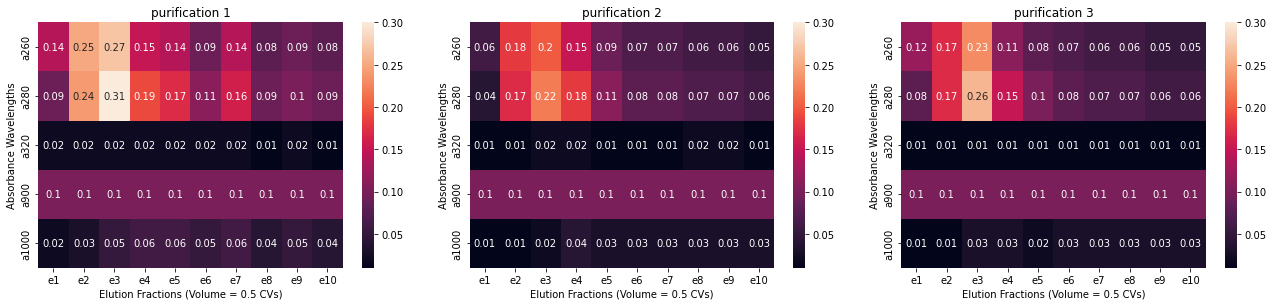

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from seaborn.matrix import heatmap


def process_dataset(collection, filename, wavelength_list, elution_list):

    rawdata = pd.read_csv(collection + filename, header= None)

    #how many wavelengths are there? 96 well plate dimentions assumed.
    number_of_wavelengths_tested = rawdata.shape[0]/9

    #check that the number given matches reality
    if int(number_of_wavelengths_tested) != len(wavelength_list):
        raise Exception('Number of wavelengths given does not equal number of wavelengths measured in ' + filename + ". Given: "+ str(len(wavelength_list))+ " vs Measured: "+ str(int(number_of_wavelengths_tested)))

    #divide up data file into discrete wavelength packets stored in a dictionary

    wavelength_dict = {}

    index_counter = 0
    base = index_counter

    for i in wavelength_list:
        index_counter += 9

        # make data subset its own object called data

        data = rawdata.iloc[base:index_counter,:]

        #add entry
        wavelength_dict[i] = data
    
        base = index_counter

    #empty list to store the averaged and blank subtracted values in later
    processed_wavelength_series_list = []

    # data processing
    for i in wavelength_dict:

        # assign first column as rownames and delete
        wavelength_dict[i].index = wavelength_dict[i].iloc[:,0]
        del wavelength_dict[i][0]

        # assign elution list as colnames
        wavelength_dict[i].columns = elution_list

        #delete first row
        wavelength_dict[i] = wavelength_dict[i].drop('<>')

        # drop all rows not indexed as A, B or C
        wavelength_dict[i] = wavelength_dict[i].loc[['A','B','C'],:]

        # pandas transpose
        wavelength_dict[i] = wavelength_dict[i].transpose()

        # average
        wavelength_dict[i]['Mean'] = wavelength_dict[i].mean(axis=1)

        # blank subtract
        wavelength_dict[i]['Normalised'] = wavelength_dict[i]['Mean'] - wavelength_dict[i].loc['blank1','Mean']

        # make series for heatmap later

        wavelength_dict[i][i] = wavelength_dict[i]['Normalised'].transpose()

        heatmap_series = wavelength_dict[i][i]

        #drop the blanks
        heatmap_series = heatmap_series.drop(['blank1', 'blank2'])

        #round to 2 decimal places
        heatmap_series = heatmap_series.round(2)

        # save in the list
        processed_wavelength_series_list.append(heatmap_series)
    
    return pd.DataFrame(processed_wavelength_series_list)

    
        




wavelength_list = ["a260", "a280", "a320", "a900", "a1000"]
elution_list = ["e1","e2","e3","e4","e5","e6","e7","e8","e9","e10","blank1", "blank2"]

crunched_data = []
filenames = []

os.getcwd()
collection = "data/"
for i, filename in enumerate(os.listdir(collection)):

    df = process_dataset(collection, filename, wavelength_list, elution_list)

    crunched_data.append(df)
    filenames.append(filename)

# Plot

fig, axes = plt.subplots(1,len(crunched_data), figsize=(18,4), sharex=True, sharey=False)
fig.tight_layout(w_pad=2)
#fig.ylabel('common ylabel')

for i in range(len(crunched_data)):
    #plot heatmap
    sns.heatmap(crunched_data[i], annot=True, ax = axes[i], vmax=0.3)

    # get title
    title = filenames[i]
    title = title[:-4]
    number = title[-1]
    title = title[:-1]
    title = title + " " + number
    axes[i].set_title(title)
    
    #set axis labels
    axes[i].set_xlabel('Elution Fractions (Volume = 0.5 CVs)')
    axes[i].set_ylabel('Absorbance Wavelengths')

